## **Qmio Error Analysis.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qmioanalyzer import read_data, ErrorAnalyzer, ErrorVisualizer

# plt.rcParams.update(plt.rcParamsDefault)
# #plt.rcParams["figure.figsize"] = [8.0, 5.50]
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 18
# plt.rcParams['font.family'] = "serif"

In [2]:
output_graphs = False

### **1. $T_1$ measurements**

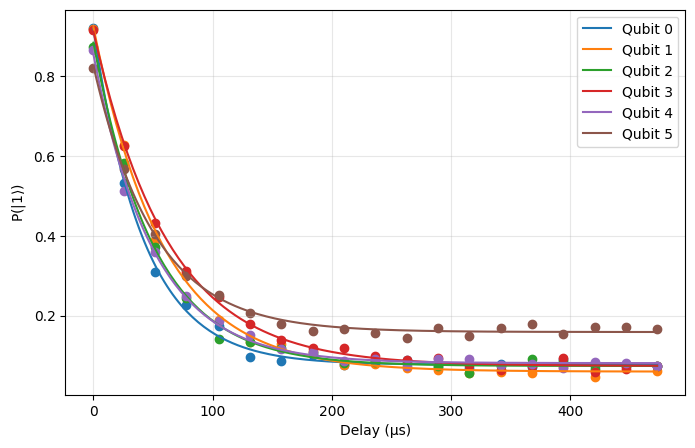

Qubit 0: T1 = 42.52 ± 1.24 µs
Qubit 1: T1 = 57.99 ± 1.73 µs
Qubit 2: T1 = 50.87 ± 1.66 µs
Qubit 3: T1 = 63.02 ± 1.46 µs
Qubit 4: T1 = 50.14 ± 1.40 µs
Qubit 5: T1 = 51.15 ± 1.72 µs


In [3]:
# load results
data = pd.read_csv("data/t1_qmio_results2.csv")

# define the exponential model
def exp_decay(t, A, T1, B):
    return A * np.exp(-t / T1) + B

# store results with uncertainties
t1_values = {}

plt.figure(figsize=(8,5))

for qubit in data["qubit"].unique():
    qubit_data = data[data["qubit"] == qubit]
    t = qubit_data["delay_us"].values
    p1 = qubit_data["p1"].values
    
    # initial guesses: A=1, T1=100, B=0
    popt, pcov = curve_fit(exp_decay, t, p1, p0=[1.0, 100.0, 0.0])
    perr = np.sqrt(np.diag(pcov))  # standard errors
    
    A, T1, B = popt
    dA, dT1, dB = perr
    
    t1_values[qubit] = (T1, dT1)
    
    # plot fit
    t_fit = np.linspace(min(t), max(t), 200)
    plt.scatter(t, p1)
    plt.plot(t_fit, exp_decay(t_fit, *popt), label=f"Qubit {qubit}")

plt.xlabel("Delay (µs)")
plt.ylabel(r"P($|1\rangle$)")
plt.legend()
plt.grid(alpha=0.3)
if output_graphs:   
    plt.savefig("T1_fits.pdf", format='pdf')
plt.show()

# print extracted T1s with errors
for q, (T1, dT1) in t1_values.items():
    print(f"Qubit {q}: T1 = {T1:.2f} ± {dT1:.2f} µs")


### **2. $T_2^*$ measurements**

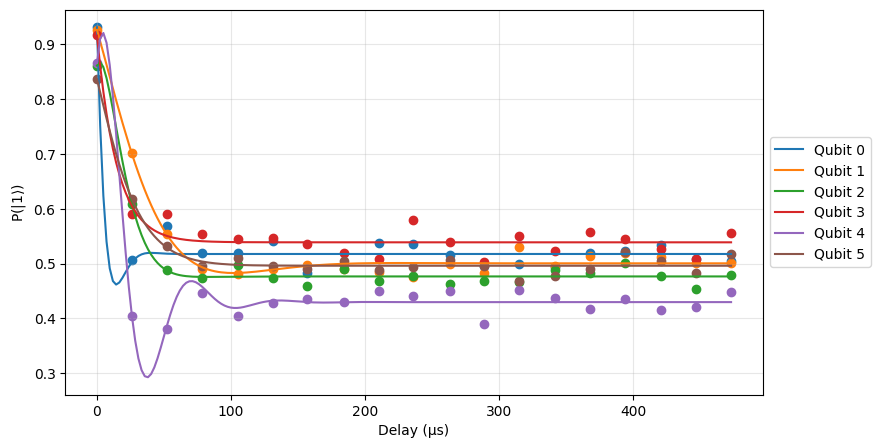


Qubit 0:
  A      = 0.5175 ± 0.0059
  B      = 0.5004 ± 72020.2904
  T2*    = 7.8744 ± 18814.8514
  Delta  = 0.0192 ± 70.0832
  phi    = 2.1692 ± 211094.9777

Qubit 1:
  A      = 0.5004 ± 0.0041
  B      = 0.4435 ± 0.0543
  T2*    = 36.0155 ± 9.5252
  Delta  = 0.0041 ± 0.0010
  phi    = 1.2871 ± 0.4087

Qubit 2:
  A      = 0.4765 ± 0.0036
  B      = 1.0000 ± 4.3097
  T2*    = 12.9196 ± 25.5350
  Delta  = 0.0063 ± 0.0041
  phi    = 0.3946 ± 1.7939

Qubit 3:
  A      = 0.5388 ± 0.0064
  B      = 0.4366 ± 795340.3653
  T2*    = 14.9991 ± 152908.9970
  Delta  = 0.0000 ± 185.0618
  phi    = 1.0415 ± 3114373.0526

Qubit 4:
  A      = 0.4297 ± 0.0042
  B      = 0.6277 ± 0.4608
  T2*    = 25.8671 ± 3.8336
  Delta  = 0.0152 ± 0.0037
  phi    = 0.7685 ± 0.7054

Qubit 5:
  A      = 0.4960 ± 0.0040
  B      = 0.9816 ± 28.0410
  T2*    = 16.3429 ± 59.6436
  Delta  = 0.0019 ± 0.0432
  phi    = 0.3536 ± 10.5442


In [4]:
data = pd.read_csv("data/t2_qmio_results2.csv")

# --- Define exponential decay function for Ramsey (centered at 0.5) ---
def ramsey_osc(t, A, B, T2, Delta, phi):
    return A + B * np.sin(2*np.pi*Delta*t + phi) * np.exp(-t/T2)


p0pt_delta = [0.01, 0.01, 0.01, 0, 0.01, 0.01] 

# Dictionary to store T2* for each qubit (with errors)
fit_results = {}
plt.figure(figsize=(9,5))
for idx, qubit in enumerate(data["qubit"].unique()):
    qubit_data = data[data["qubit"] == qubit]
    t = qubit_data["delay_us"].values
    p1 = qubit_data["p1"].values
    
    # initial guess: A=0.5, B=0.5, T2=200, Delta=0.01, phi=0
    popt, pcov = curve_fit(
        ramsey_osc, t, p1, 
        p0=[np.mean(p1), (np.max(p1) - np.min(p1)) / 2, 40, p0pt_delta[idx], 0],
        bounds=([0, 0, 0, 0, -np.pi], [1, 1, np.inf, 0.4, np.pi]),
        maxfev=10000
        
    )
    perr = np.sqrt(np.diag(pcov))  # 1σ errors on the fit parameters
    
    # unpack parameters
    A, B, T2, Delta, phi = popt
    dA, dB, dT2, dDelta, dphi = perr
    
    # store all parameters in dictionary
    fit_results[qubit] = {
        "A": (A, dA),
        "B": (B, dB),
        "T2*": (T2, dT2),
        "Delta": (Delta, dDelta),
        "phi": (phi, dphi),
    }
    
    # smooth fit line
    t_fit = np.linspace(min(t), max(t), 200)
    plt.scatter(t, p1)
    plt.plot(t_fit, ramsey_osc(t_fit, *popt), label=f"Qubit {qubit}")

plt.xlabel("Delay (µs)")
plt.ylabel(r"P($|1\rangle$)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(alpha=0.3)
if output_graphs:  
    plt.savefig("T2star_fits.pdf", format='pdf')
plt.show()

# print extracted parameters with uncertainties
for q, params in fit_results.items():
    print(f"\nQubit {q}:")
    for name, (val, err) in params.items():
        print(f"  {name:6s} = {val:.4f} ± {err:.4f}")

In [5]:
color_true_dark = "#CC220E"
color_true = "#DB331F"
color_true_light = "#FA9696"
color_true_light_dark = "#E37474"
color_anti_true = "#10CEE3"

color_false_dark = "#0F6FB8"
color_false = "#1F86DB"
color_false_light = "#72BAF7"
color_false_light_dark = "#599DD9"
color_anti_false = "#FF940D"


color_both_dark = "#611299"
color_both = "#8F40C7"
color_both_light = "#C397E8"
color_both_light_dark = "#9F79BD"
color_anti_both = "#16AB55"

color_0 = "#2e1e3b"


color_1 = "#413d7b"
color_1_light = "#7873BA"
color_1_light_dark = "#5A54AB"

color_2 = "#37659e"

color_3 = "#338fa7"
color_3_light = "#82C7D9"
color_3_light_dark = "#5FB8CE"


color_4 = "#41b7ad"

color_5 = "#8bdab2"
color_5_light = "#C9EEDB"
color_5_light_dark = "#A6E3C3"

color_magma_0 = "#221250"
color_magma_1 = "#5f177f"
color_magma_2 = "#982d80"
color_magma_3 = "#d3436e"
color_magma_4 = "#f8765c"
color_magma_5 = "#febb81"

## **Low period circuit.**

### **3. Error distributions.**

In [6]:
bits, rep, init, backend, extra = read_data("data/results_cosmic_3.txt")

In [7]:
print("Bitstrings:", bits[:5])     # first 5 measured states
print("Repetition period:", rep)
print("Init state:", init)
print("Backend:", backend)
print("Batch IDs:", extra.get("batch"))
print("Shot IDs:", extra.get("shot"))
print("Abs times:", extra.get("abstime"))


Bitstrings: ['001011' '000100' '010111' '010101' '110011']
Repetition period: 1.5e-05
Init state: None
Backend: qmio
Batch IDs: [  1   1   1 ... 815 815 815]
Shot IDs: [      1       2       3 ... 6676478 6676479 6676480]
Abs times: [  1.185189   1.185189   1.185189 ... 954.625391 954.625391 954.625391]


In [8]:
errors_obj = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=2)
errors_dict = errors_obj.get_errors()

The analysis was performed using the *low repetition period* approach 
(repetition_period < 5e-10 μs). The error dictionary contains:

- Key: 'low_period_errors' → A dictionary with 6676479 measurements with the following subkeys:
  - 'true_errors': Array with the number of true errors (0 expected, 1 measured) for each measurement.
  - 'false_errors': Array with the number of false errors (1 expected, 0 measured) for each measurement.
  - 'total_errors': Array with the total number of errors for each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [9]:
states = errors_dict["low_period_errors"]["states"]
expected = errors_dict["low_period_errors"]["expected"]
true_errors = errors_dict['low_period_errors']['true_errors']
false_errors = errors_dict['low_period_errors']['false_errors']
total_errors = errors_dict['low_period_errors']['total_errors']
times = errors_dict['low_period_errors']['times']


print('number of true errors:',sum(true_errors))
print('number of false errors:',sum(false_errors))
print('number of total errors:',sum(total_errors))


number of true errors: 11134021
number of false errors: 4707769
number of total errors: 15841790


In [10]:
print(times[:5], times[-5:])
print(extra.get("abstime")[1:5], extra.get("abstime")[-5:])

[0.0, 1.5e-05, 3e-05, 4.5e-05, 6e-05] [100.14711, 100.147125, 100.14714000000001, 100.147155, 100.14717]
[1.185189 1.185189 1.185189 1.185189] [954.625391 954.625391 954.625391 954.625391 954.625391]


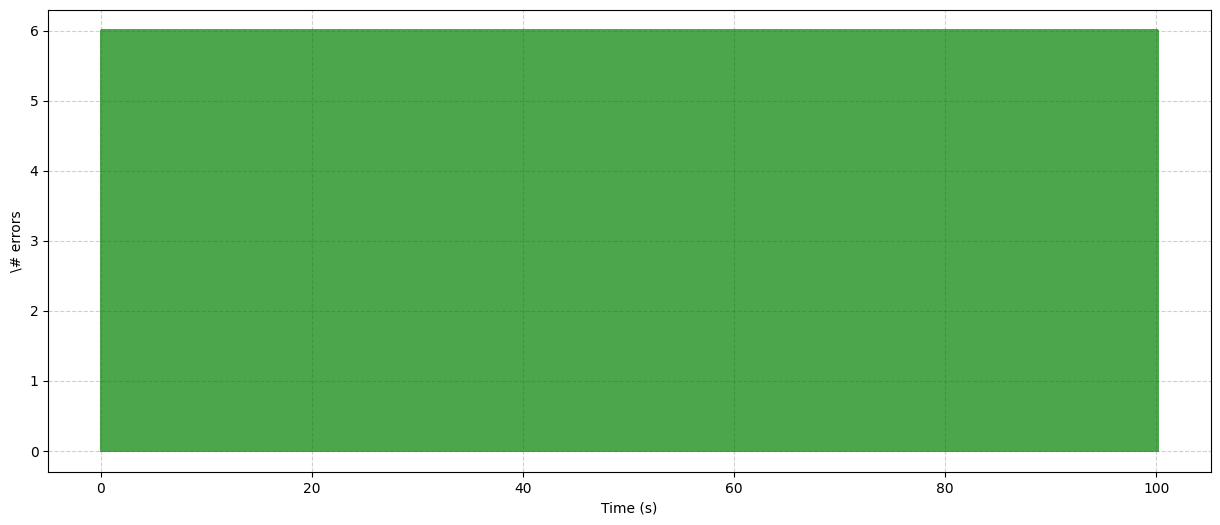

In [11]:
plt.figure(figsize=(15,6))
plt.plot(times, total_errors, '-', color = 'green', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

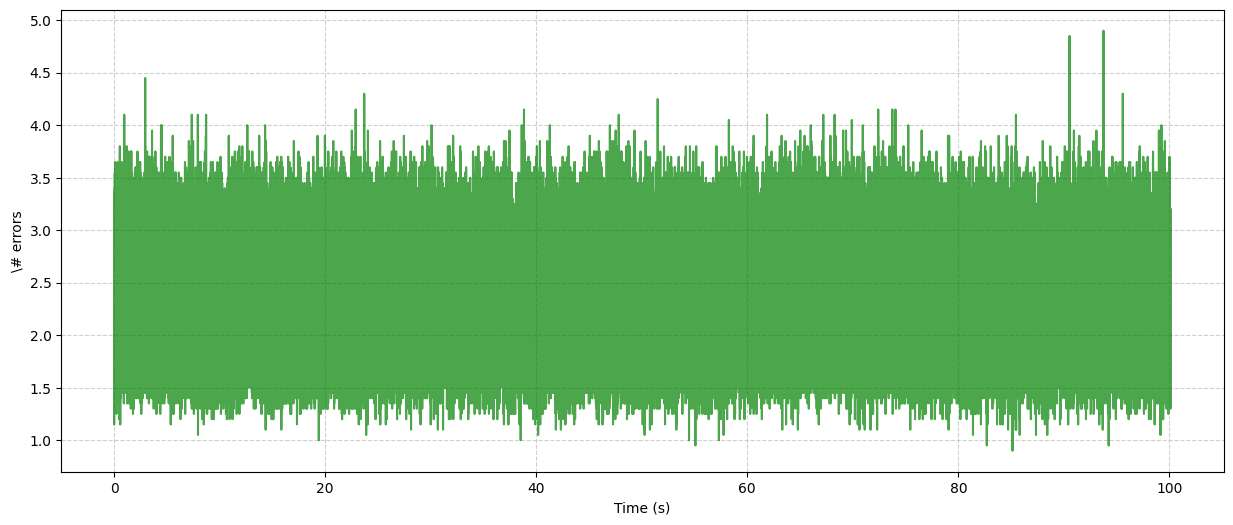

In [12]:
# Example: group every 6 points
bin_size = 20

# convert to arrays
times = np.array(times)
total_errors = np.array(total_errors)

# number of full bins
n_bins = len(total_errors) // bin_size

# reshape and take mean
binned_times = times[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color='green', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mean number of errors: 2.372777939207304


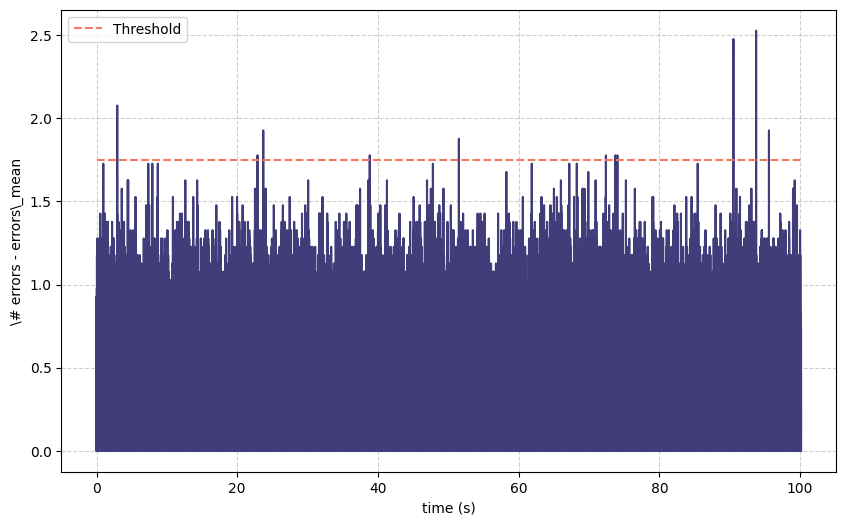

In [13]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
signal = binned_errors - baseline  # subtract baseline
print('mean number of errors:', baseline)

# optionally clip negatives to zero (if you only care about positive peaks)
signal = np.clip(signal, 0, None)
threshold = 1.75

# ---------------- PLOT ----------------
plt.figure(figsize=(10,6))
plt.plot(binned_times, signal, '-', color=color_1,)
plt.hlines(threshold, xmin=binned_times[0], xmax=binned_times[-1], color=color_magma_4, linestyle='--', label='Threshold')
plt.xlabel("time (s)")
plt.ylabel(r"\# errors - errors\_mean")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
if output_graphs:  
    plt.savefig("error_times_low.pdf", format='pdf')
plt.show()

In [14]:
# ---------------- PARAMETERS ----------------
threshold = 1.75
window_before = 0.1  # seconds
window_after  = 0.3  # seconds

# ---------------- FIND PEAKS ON BINNED SIGNAL ----------------
peak_indices = np.where(signal > threshold)[0]

# avoid duplicates if consecutive bins are above threshold
selected_peaks = []
for idx in peak_indices:
    if not selected_peaks or (idx - selected_peaks[-1]) > 1:
        selected_peaks.append(idx)

print(f"Found {len(selected_peaks)} candidate peaks")

# ---------------- EXTRACT FROM RAW DATA ----------------
for peak_idx in selected_peaks:
    t_peak = binned_times[peak_idx]
    print(f"Peak at t = {t_peak:.3f} s")
    
    # define window in raw times
    t_min = t_peak - window_before
    t_max = t_peak + window_after
    
    # mask on raw data
    mask = (times >= t_min) & (times <= t_max)
    
    # plot raw errors around peak
    # plt.figure(figsize=(10,4))
    # plt.plot(times[mask], total_errors[mask], 'o-', color='purple')
    # plt.axhline(np.mean(total_errors), color='gray', linestyle='--', alpha=0.7, label="mean noise")
    # plt.axvline(t_peak, color='black', linestyle=':', label="peak")
    # plt.xlabel("Time (s)")
    # plt.ylabel(r"\# errors (raw)")
    # plt.title(f"Raw errors around peak at t = {t_peak:.3f} s")
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.show()


Found 15 candidate peaks
Peak at t = 2.947 s
Peak at t = 22.889 s
Peak at t = 23.700 s
Peak at t = 38.839 s
Peak at t = 51.510 s
Peak at t = 72.409 s
Peak at t = 73.745 s
Peak at t = 74.040 s
Peak at t = 90.535 s
Peak at t = 90.536 s
Peak at t = 90.537 s
Peak at t = 90.537 s
Peak at t = 90.538 s
Peak at t = 93.757 s
Peak at t = 95.584 s


In [15]:
error_vis = ErrorVisualizer(error_obj=errors_obj)
period = "low"

The analysis was performed using the *low repetition period* approach 
(repetition_period < 5e-10 μs). The error dictionary contains:

- Key: 'low_period_errors' → A dictionary with 6676479 measurements with the following subkeys:
  - 'true_errors': Array with the number of true errors (0 expected, 1 measured) for each measurement.
  - 'false_errors': Array with the number of false errors (1 expected, 0 measured) for each measurement.
  - 'total_errors': Array with the total number of errors for each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




[DEBUG] Experimental keys: 64
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 6676479, Total theo: 6676479.000000004
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


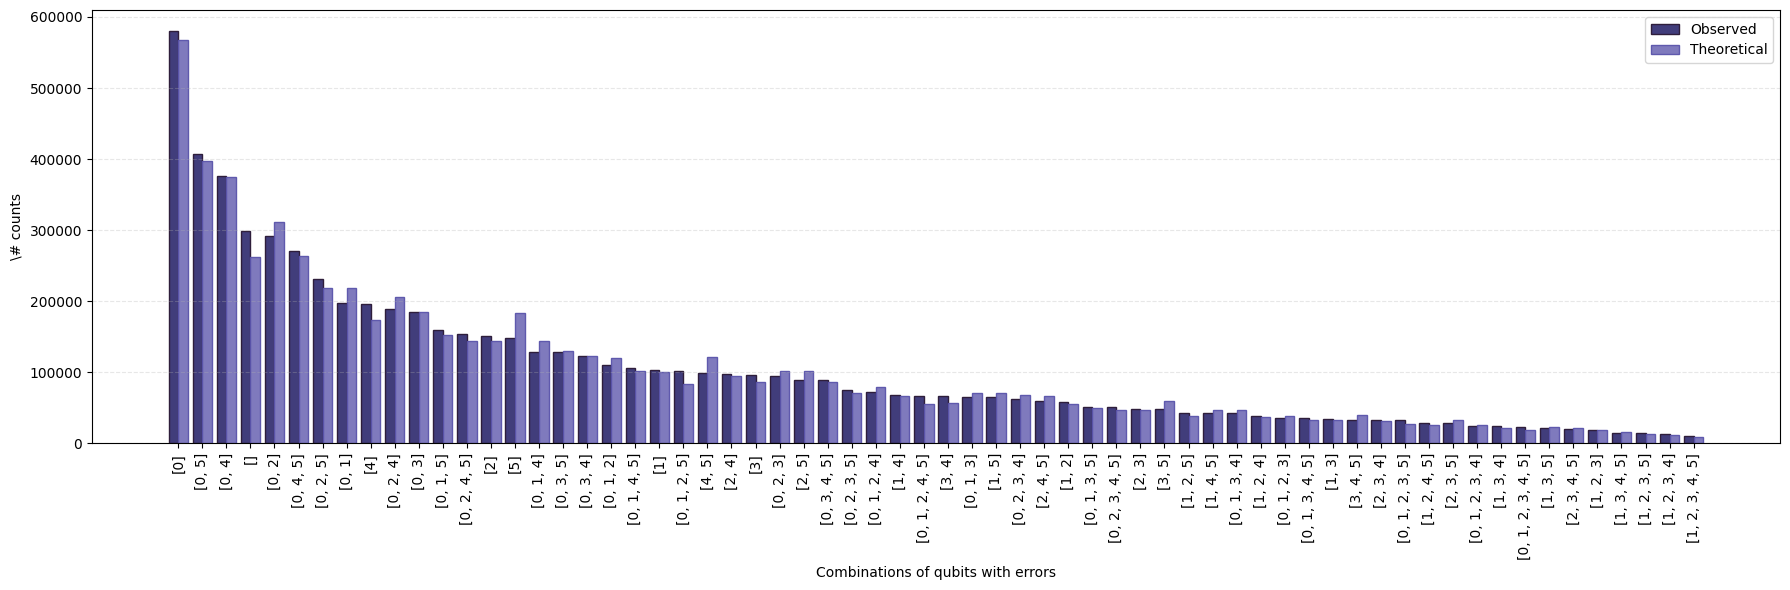

In [16]:
labels_both, observed_counts, theoretical_counts = error_vis.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

# colors1 : Observed - lawngreen, Theoretical - darkviolet

plt.figure(figsize=(18, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color=color_1, edgecolor=color_0)
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color=color_1_light,alpha = 0.95, edgecolor=color_1_light_dark)
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_low.pdf", format='pdf')
plt.show()

In [17]:
total_errors, true_errors, false_errors = error_vis.get_error_counts(period)

True errors: If a 0 measurement is expected and instead we measure a 1.
False errors:  If a 1 measurement is expected and instead we measure a 0.
Number of true errors: 11134021
Number of false errors 4707769


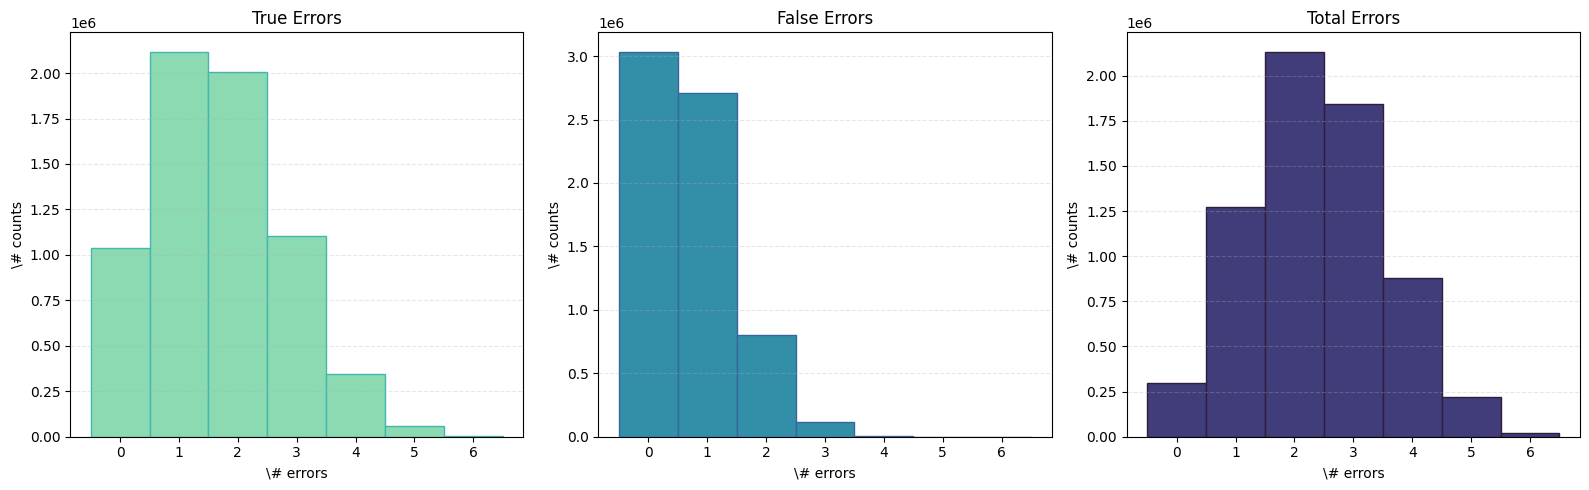

In [18]:
print("True errors: If a 0 measurement is expected and instead we measure a 1.")
print("False errors:  If a 1 measurement is expected and instead we measure a 0.")

print('Number of true errors:',sum(true_errors))
print('Number of false errors', sum(false_errors))

plt.figure(figsize=(16, 5))

    # Histograma de True Errors
plt.subplot(1, 3, 1)
plt.hist(true_errors, bins=range(max(true_errors)+2), edgecolor=color_4, align='left', color=color_5)
plt.title("True Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Histograma de False Errors
plt.subplot(1, 3, 2)
plt.hist(false_errors, bins=range(max(false_errors)+2), edgecolor=color_2, align='left', color=color_3)
plt.title("False Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")

plt.grid(axis='y', linestyle='--', alpha=0.3)


plt.subplot(1,3,3)
plt.hist(total_errors, bins=range(min(total_errors), max(total_errors) + 2), color=color_1,align='left', edgecolor=color_0)
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.title("Total Errors")
#plt.xticks(range(min(total_errors), max(total_errors) + 1))  # Asegurar que los ticks sean enteros
#plt.show()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_histograms_low.pdf", format='pdf')
plt.show()

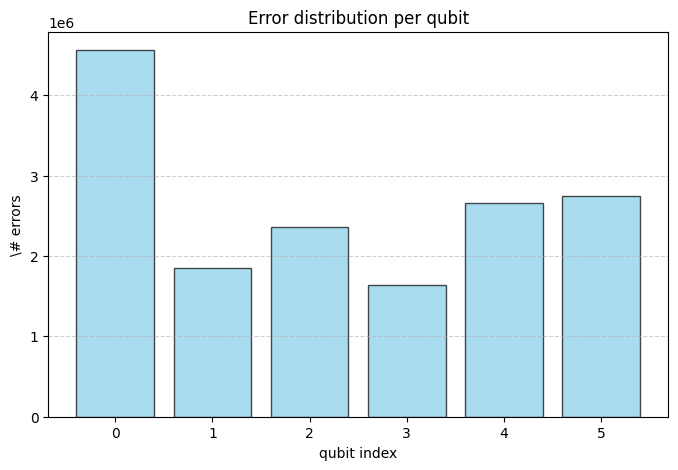

In [19]:
errors_per_qubit = errors_dict["low_period_errors"]["errors_per_qubit"]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(range(len(errors_per_qubit)), errors_per_qubit, color='skyblue', alpha=0.7, edgecolor='black')

# Etiquetas
plt.xlabel("qubit index")
plt.ylabel(r"\# errors")
plt.title("Error distribution per qubit")
plt.xticks(range(len(errors_per_qubit)))  # Marcamos los qubits en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [20]:
print("Errors per qubit:", np.array(errors_per_qubit)/sum(errors_per_qubit))

Errors per qubit: [0.28808916 0.11706442 0.14944006 0.10384079 0.16781159 0.17375398]


## **Possible cosmic ray impact ?**

Found 15 candidate peaks
Peak at t = 2.947 s
Peak at t = 22.889 s
Peak at t = 23.700 s
Peak at t = 38.839 s
Peak at t = 51.510 s
Peak at t = 72.409 s
Peak at t = 73.745 s
Peak at t = 74.040 s
Peak at t = 90.535 s
Peak at t = 90.536 s
Peak at t = 90.537 s
Peak at t = 90.537 s
Peak at t = 90.538 s
Peak at t = 93.757 s
Peak at t = 95.584 s

In [21]:
times = [2.94715, 22.8892, 23.7002, 38.8393, 51.5095, 72.4087, 73.7445, 74.0397, 90.5353, 93.7569, 95.5843]
window_high = [0.008, 0.003, 0.008, 0.003, 0.003, 0.003, 0.003, 0.003, 0.01, 0.006, 0.003]
do_fit = [True, False, True, False, False, False, False, False, True, True, False]

In [22]:
# --- Model for exponential decay after a cosmic ray ---
def exp_decay_peak(t, A, tau, B, t0):
    """Exponential decay starting at t0."""
    return np.where(t >= t0, A * np.exp(-(t - t0) / tau) + B, B)

In [23]:

results = {}
window_low = -0.002  # seconds before peak


for idx, t_center in enumerate(times):
    
    errors_obj_sel = ErrorAnalyzer(
        repetition_period = rep,
        init_state = init,
        measurements = bits,
        verbose = 0, 
        center_time = t_center,
        window = (window_low, window_high[idx])
    )
    errors_dict_sel = errors_obj_sel.get_errors()

    total_errors_sel = np.array(errors_dict_sel['low_period_errors']['total_errors'])
    times_sel = np.array(errors_dict_sel['low_period_errors']['times'])

    # --- If fit is disabled, just plot the raw data ---
    if not do_fit[idx]:
        print(f"Event {idx}: skipped fit, only plotting data.")
        
        plt.figure(figsize=(7,6))
        plt.plot(times_sel, total_errors_sel, '-', color=color_1, linewidth=1, alpha=0.9)
        plt.vlines(t_center, ymin=total_errors_sel.min(), ymax=total_errors_sel.max(),
                   color=color_magma_4, linestyles='dashed', linewidth=1.5, label="Impact time")
        plt.xlabel("time (s)")
        plt.ylabel(r"\# errors")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        
        if output_graphs:
            plt.savefig(f"cr_low_{idx}.pdf", format='pdf')
        plt.close()
        continue

    # --- If fit is enabled ---
    mask = (times_sel > t_center) & (times_sel < t_center + 0.01)
    t_fit_data = times_sel[mask]
    y_fit_data = total_errors_sel[mask]

    if len(t_fit_data) < 5:
        print(f"Skipping index {idx}, not enough points in window.")
        continue

    try:
        # fit parameters (fix t0)
        popt, pcov = curve_fit(
            lambda t, A, tau, B: exp_decay_peak(t, A, tau, B, t_center),
            t_fit_data, y_fit_data,
            p0=[max(y_fit_data), 0.005, min(y_fit_data)],
            maxfev=20000
        )
        A, tau, B = popt
        dA, dtau, dB = np.sqrt(np.diag(pcov))

        # chi-square
        residuals = y_fit_data - exp_decay_peak(t_fit_data, A, tau, B, t_center)
        chi2 = np.sum(residuals**2)
        dof = len(y_fit_data) - len(popt)
        chi2_red = chi2 / dof if dof > 0 else np.nan

        results[idx] = (tau, dtau, chi2, dof, chi2_red)

        # --- Plot with fit ---
        plt.figure(figsize=(7,6))
        plt.plot(times_sel, total_errors_sel, '-', color=color_1, linewidth=1, alpha=0.9)
        t_fit_line = np.linspace(t_center, t_center + window_high[idx], 500)
        plt.plot(t_fit_line, exp_decay_peak(t_fit_line, A, tau, B, t_center),
                 color=color_magma_4, linewidth=2, label="Exponential fit")
        plt.vlines(t_center, ymin=total_errors_sel.min(), ymax=total_errors_sel.max(),
                   color=color_magma_4, linestyles='dashed', linewidth=2, label="Impact time")
        plt.xlabel("time (s)")
        plt.ylabel(r"\# errors")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        if output_graphs:
            plt.savefig(f"cr_low_{idx}.pdf", format='pdf')
        plt.close()

        # --- Print results ---
        print(f"Event {idx}: t0 = {t_center:.3f} s")
        print(f"   τ = {tau*1000:.2f} ± {dtau*1000:.2f} ms")
        print(f"   χ² = {chi2:.2f}, dof = {dof}, χ²_red = {chi2_red:.2f}")

    except RuntimeError:
        print(f"Fit did not converge for event {idx}.")


Event 0: t0 = 2.947 s
   τ = 0.96 ± 0.26 ms
   χ² = 745.60, dof = 530, χ²_red = 1.41
Event 1: skipped fit, only plotting data.
Event 2: t0 = 23.700 s
   τ = 2.14 ± 0.57 ms
   χ² = 754.27, dof = 529, χ²_red = 1.43
Event 3: skipped fit, only plotting data.
Event 4: skipped fit, only plotting data.
Event 5: skipped fit, only plotting data.
Event 6: skipped fit, only plotting data.
Event 7: skipped fit, only plotting data.
Event 8: t0 = 90.535 s
   τ = 3.89 ± 0.74 ms
   χ² = 974.31, dof = 663, χ²_red = 1.47
Event 9: t0 = 93.757 s
   τ = 0.56 ± 0.11 ms
   χ² = 593.78, dof = 396, χ²_red = 1.50
Event 10: skipped fit, only plotting data.


In [24]:
t_center = times[8]

errors_obj_sel = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=0, 
                               center_time=t_center, window=(-0.0001, 0.00268))
error_vis_sel = ErrorVisualizer(errors_obj_sel)

errors_dict_sel = errors_obj_sel.get_errors()

states_sel = errors_dict_sel["low_period_errors"]["states"]
total_errors_sel = np.array(errors_dict_sel['low_period_errors']['total_errors'])
times_sel = np.array(errors_dict_sel['low_period_errors']['times'])

[DEBUG] Experimental keys: 42
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 185, Total theo: 185.00000000000003
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


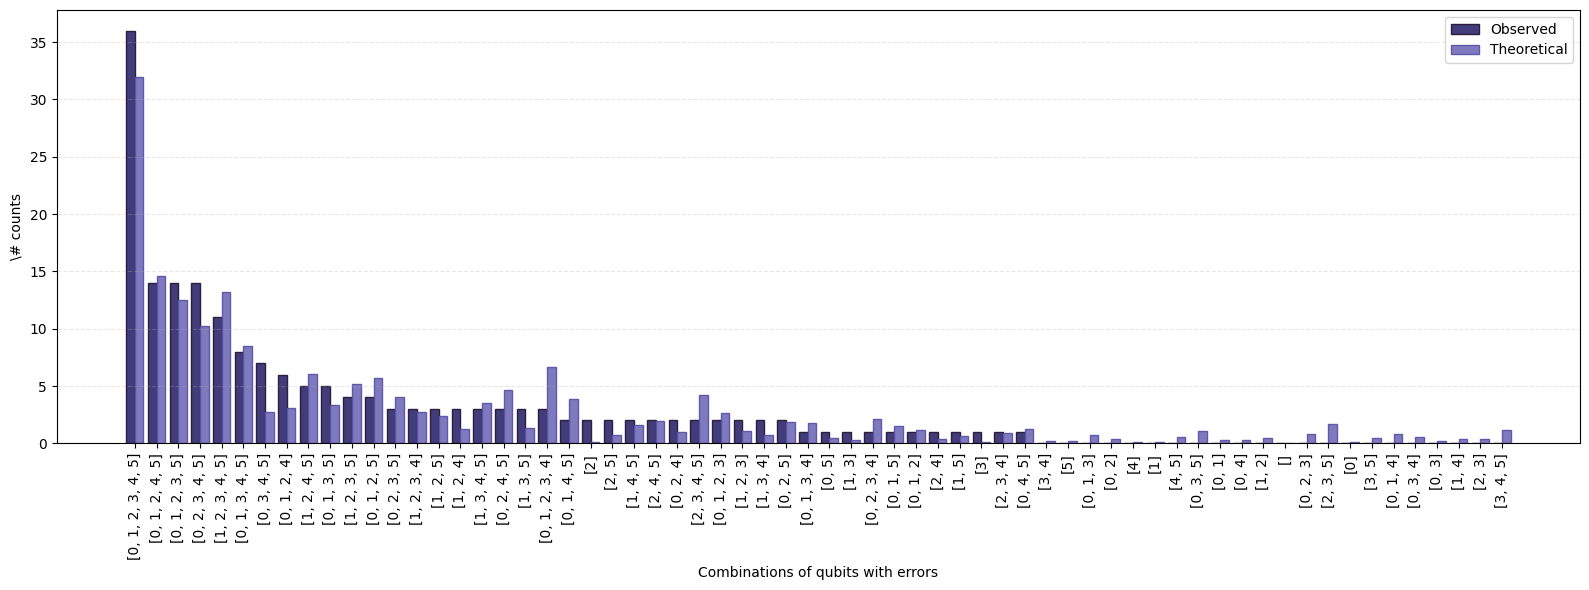

In [25]:
labels_both, observed_counts, theoretical_counts = error_vis_sel.get_error_patterns(period='low', type="both", threshold=0.0)


# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color=color_1, edgecolor=color_0)
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color=color_1_light,alpha = 0.95, edgecolor=color_1_light_dark)
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_low_cr.pdf", format='pdf')
plt.show()


In [26]:
t_center = times[8]
qubits_probabilities = [0.28808916, 0.11706442, 0.14944006, 0.10384079, 0.16781159, 0.17375398]

errors_obj_sel = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=0, 
                               center_time=t_center, window=(-0.0001, 0.00268), external_error_probs=qubits_probabilities)
error_vis_sel = ErrorVisualizer(errors_obj_sel)

errors_dict_sel = errors_obj_sel.get_errors()

states_sel = errors_dict_sel["low_period_errors"]["states"]
total_errors_sel = np.array(errors_dict_sel['low_period_errors']['total_errors'])
times_sel = np.array(errors_dict_sel['low_period_errors']['times'])

[DEBUG] Experimental keys: 42
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 185, Total theo: 184.99999999999997
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


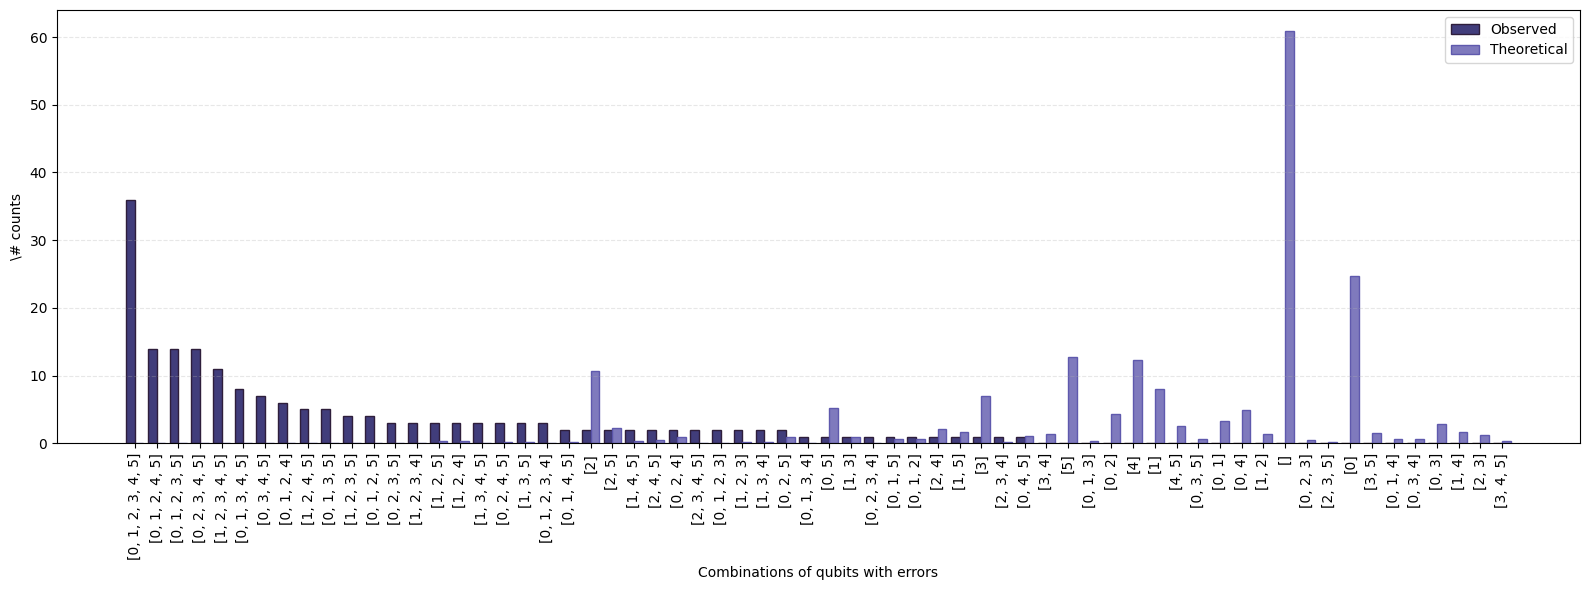

In [27]:
labels_both, observed_counts, theoretical_counts = error_vis_sel.get_error_patterns(period='low', type="both", threshold=0.0)


# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color=color_1, edgecolor=color_0)
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color=color_1_light,alpha = 0.95, edgecolor=color_1_light_dark)
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_low_cr.pdf", format='pdf')
plt.show()


In [28]:
total_errors_sel, true_errors_sel, false_errors_sel = error_vis_sel.get_error_counts(period='low')

True errors: If a 0 measurement is expected and instead we measure a 1.
False errors:  If a 1 measurement is expected and instead we measure a 0.
Number of true errors: 34
Number of false errors 796


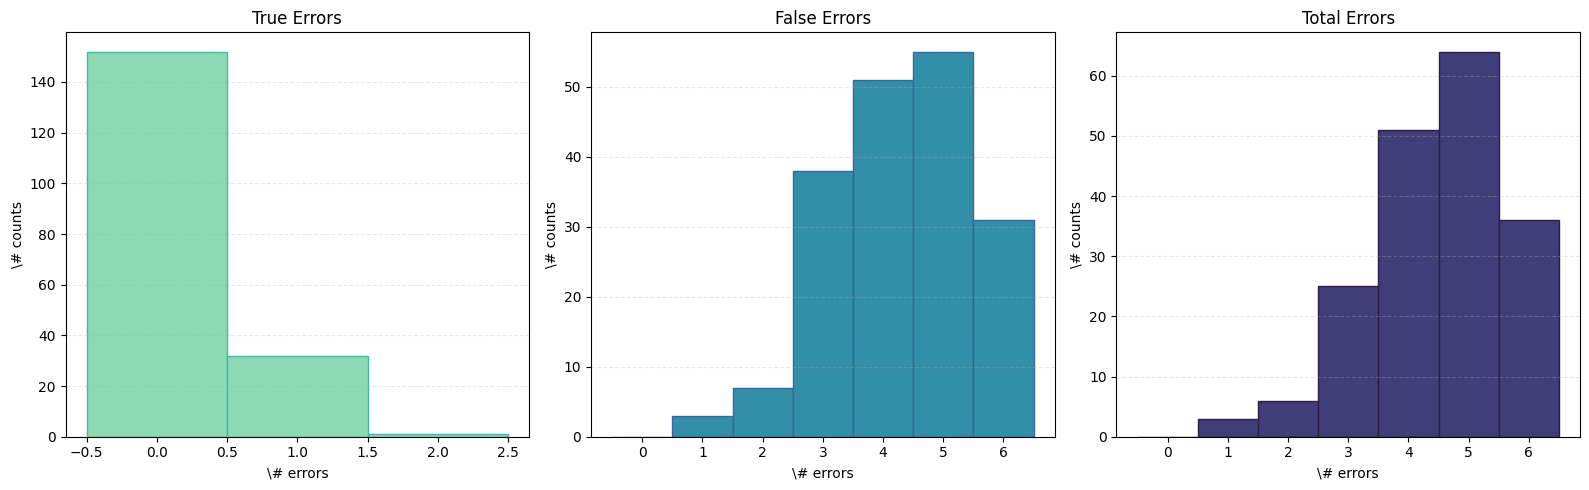

In [29]:
print("True errors: If a 0 measurement is expected and instead we measure a 1.")
print("False errors:  If a 1 measurement is expected and instead we measure a 0.")

print('Number of true errors:',sum(true_errors_sel))
print('Number of false errors', sum(false_errors_sel))


plt.figure(figsize=(16, 5))

    # Histograma de True Errors
plt.subplot(1, 3, 1)
plt.hist(true_errors_sel, bins=range(max(true_errors_sel)+2), edgecolor=color_4, align='left', color=color_5)
plt.title("True Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Histograma de False Errors
plt.subplot(1, 3, 2)
plt.hist(false_errors_sel, bins=range(max(false_errors_sel)+2), edgecolor=color_2, align='left', color=color_3)
plt.title("False Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)


plt.subplot(1,3,3)
plt.hist(total_errors_sel, bins=range(max(total_errors_sel) + 2), color=color_1, align='left', edgecolor=color_0)
plt.title("Total Errors")
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.3)
#plt.xticks(range(min(total_errors), max(total_errors) + 1))  # Asegurar que los ticks sean enteros
#plt.show()
plt.tight_layout()
if output_graphs:   
    plt.savefig("error_histograms_low_cr.pdf", format='pdf')
plt.show()


## **High period circuit.**

### **1. Initial state: $\ket{1}$**

In [30]:
bits_high_1, rep_high_1, init, backend_high_1, extra_high_1 = read_data("data/results_cosmic_high_period.txt")

In [31]:
print("Bitstrings:", bits_high_1[:5])     # first 5 measured states
print("Repetition period:", rep_high_1)
print("Init state:", init)
print("Backend:", backend_high_1)
print("Batch IDs:", extra_high_1.get("batch"))
print("Shot IDs:", extra_high_1.get("shot"))
print("Abs times:", extra_high_1.get("abstime"))


Bitstrings: ['111000' '111111' '011011' '101001' '100001']
Repetition period: 0.00015
Init state: None
Backend: qmio
Batch IDs: [ 1  1  1 ... 83 83 83]
Shot IDs: [     1      2      3 ... 679934 679935 679936]
Abs times: [  1.944018   1.944018   1.944018 ... 162.163034 162.163034 162.163034]


In [32]:
errors_obj_high = ErrorAnalyzer(repetition_period = rep_high_1, init_state = 1, measurements = bits_high_1, threshold=0.000120, verbose=2)
errors_dict_high = errors_obj_high.get_errors()

The analysis was performed using the *high repetition period* approach 
(repetition_period ≥ 1.2e-10 μs). The error dictionary contains:

- Key: 'high_period_errors' → Returns two arrays with 679936 measurements:
  - 'error_counts': Array with the number of errors associated with each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [33]:
states_high = errors_dict_high["high_period_errors"]["states"]
total_errors_high = errors_dict_high['high_period_errors']['total_errors']
times_high = errors_dict_high['high_period_errors']['times']

print('number of total errors:',sum(total_errors_high))


number of total errors: 797462


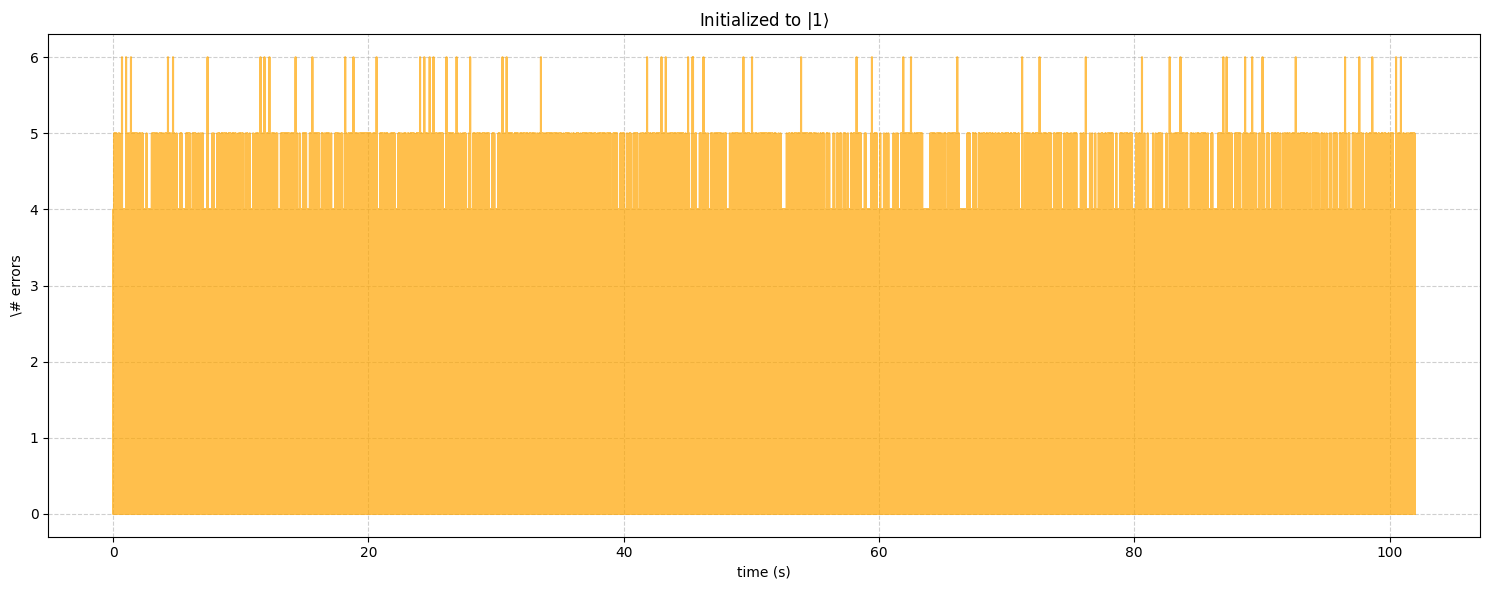

In [34]:
plt.figure(figsize=(15,6))

plt.plot(times_high, total_errors_high, '-', color = 'orange', markersize=3, alpha=0.7)

plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.title(r'Initialized to $|1\rangle$')

plt.tight_layout()
plt.show()

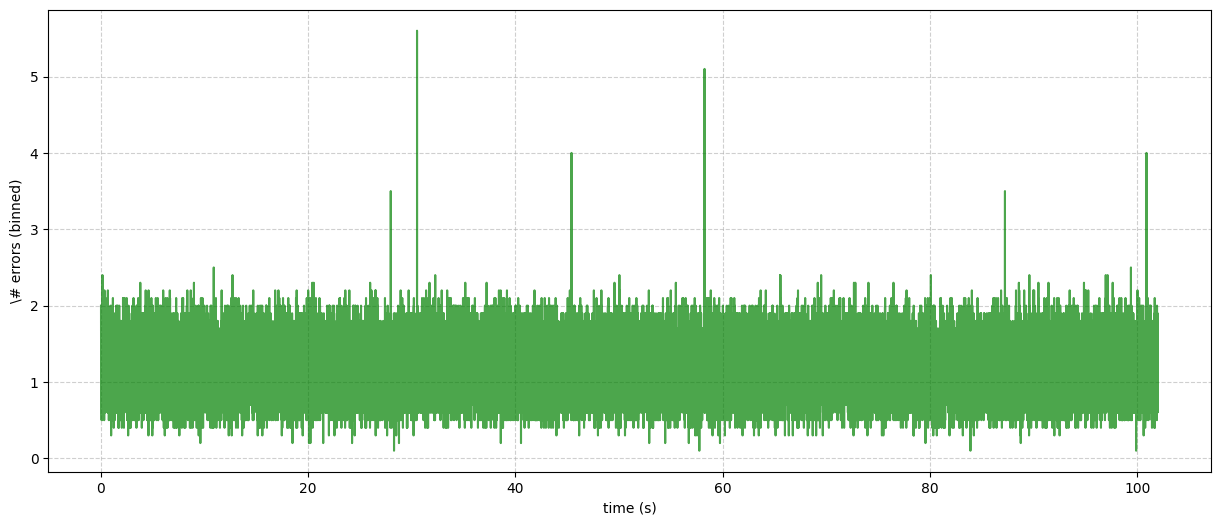

In [35]:
# Example: group every 6 points
bin_size = 10

# convert to arrays
times_high = np.array(times_high)
total_errors_high = np.array(total_errors_high)

# number of full bins
n_bins = len(total_errors_high) // bin_size

# reshape and take mean
binned_times = times_high[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors_high[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color='green', alpha=0.7)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors (binned)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mean number of errors: 1.1728472048593235


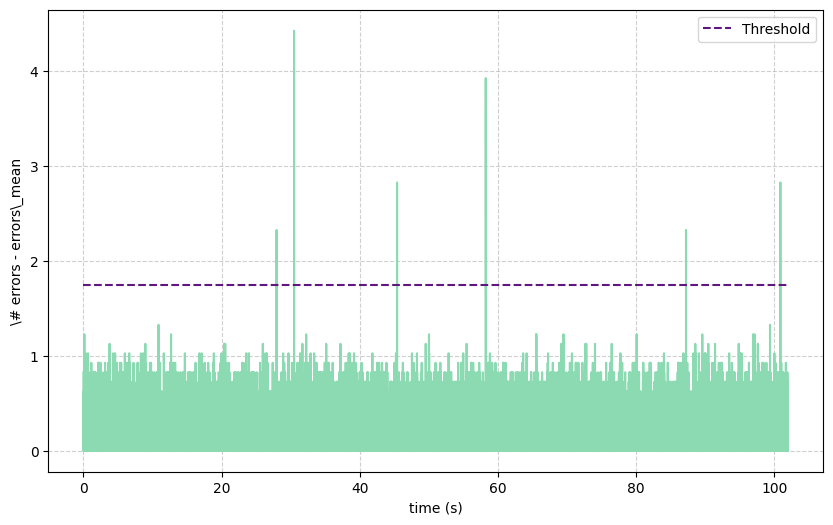

In [36]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
signal = binned_errors - baseline  # subtract baseline
print('mean number of errors:', baseline)

# optionally clip negatives to zero (if you only care about positive peaks)
signal = np.clip(signal, 0, None)
threshold = 1.75

# ---------------- PLOT ----------------
plt.figure(figsize=(10,6))
plt.plot(binned_times, signal, '-', color=color_5)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors - errors\_mean")
plt.hlines(y=threshold, xmin=binned_times[0], xmax=binned_times[-1], color=color_magma_1, linestyle='--', label='Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("errors_time_high_1.pdf", format='pdf')
plt.show()

In [37]:
# ---------------- PARAMETERS ----------------
threshold = 1.75
window_before = 0.1  # seconds
window_after  = 0.3  # seconds

# ---------------- FIND PEAKS ON BINNED SIGNAL ----------------
peak_indices = np.where(signal > threshold)[0]

# avoid duplicates if consecutive bins are above threshold
selected_peaks = []
for idx in peak_indices:
    if not selected_peaks or (idx - selected_peaks[-1]) > 1:
        selected_peaks.append(idx)

print(f"Found {len(selected_peaks)} candidate peaks")

# ---------------- EXTRACT FROM RAW DATA ----------------
for peak_idx in selected_peaks:
    t_peak = binned_times[peak_idx]
    print(f"Peak at t = {t_peak:.3f} s")
    
    # define window in raw times
    t_min = t_peak - window_before
    t_max = t_peak + window_after
    
    # mask on raw data
    mask = (times_high >= t_min) & (times_high <= t_max)

    # plot raw errors around peak
    # plt.figure(figsize=(10,4))
    # plt.plot(times_high[mask], total_errors_high[mask], 'o-', color='purple')
    # plt.axhline(np.mean(total_errors_high), color='gray', linestyle='--', alpha=0.7, label="mean noise")
    # plt.axvline(t_peak, color='black', linestyle=':', label="peak")
    # plt.xlabel("time (s)")
    # plt.ylabel(r"\# errors (raw)")
    # plt.title(f"Raw errors around peak at t = {t_peak:.3f} s")
    # plt.legend()
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.show()

Found 7 candidate peaks
Peak at t = 27.964 s
Peak at t = 30.500 s
Peak at t = 30.503 s
Peak at t = 45.409 s
Peak at t = 58.246 s
Peak at t = 87.238 s
Peak at t = 100.895 s


In [38]:
error_vis_high = ErrorVisualizer(error_obj=errors_obj_high)
period = "high"
labels, values = error_vis_high.get_states_histogram(period, obj=0)

The analysis was performed using the *high repetition period* approach 
(repetition_period ≥ 1.2e-10 μs). The error dictionary contains:

- Key: 'high_period_errors' → Returns two arrays with 679936 measurements:
  - 'error_counts': Array with the number of errors associated with each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




[DEBUG] Experimental keys: 64
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 679936, Total theo: 679936.0
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


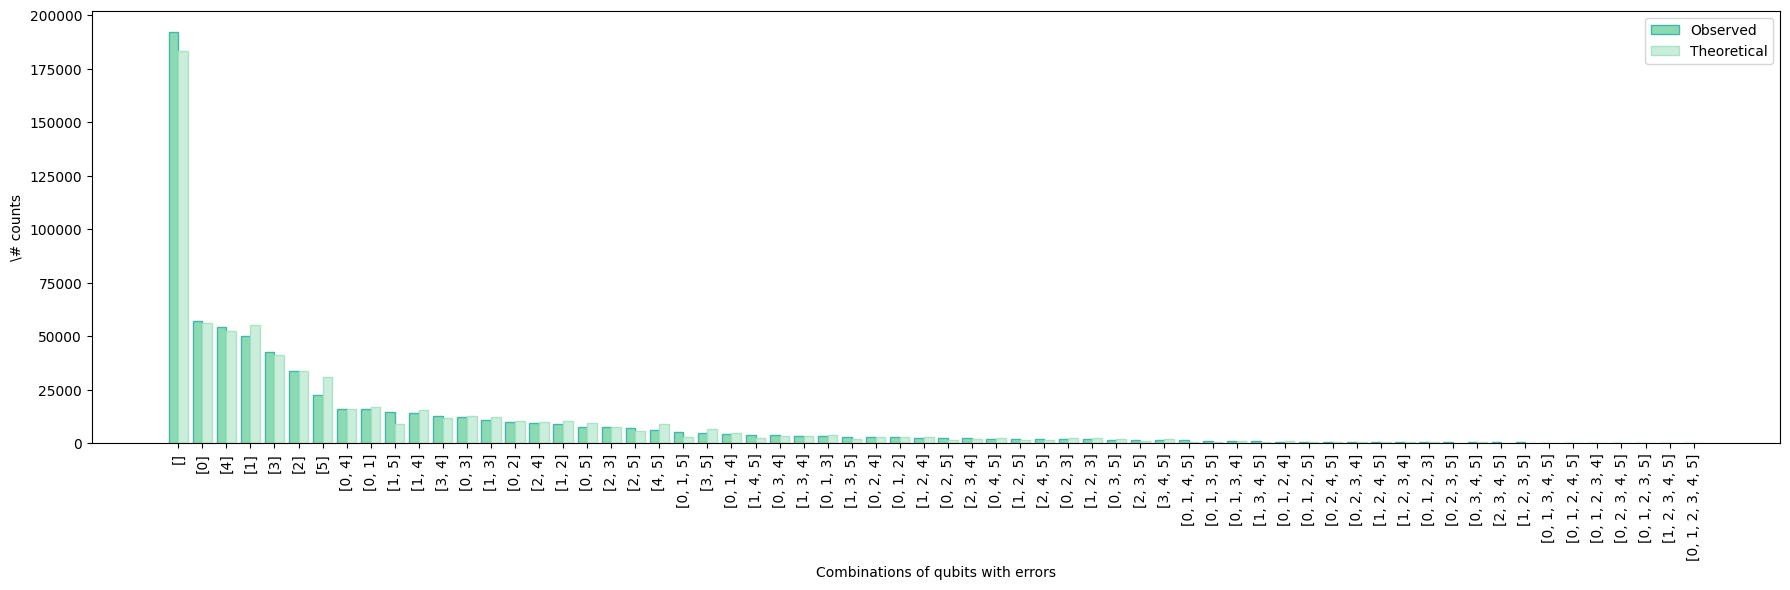

In [39]:
labels_both, observed_counts, theoretical_counts = error_vis_high.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

plt.figure(figsize=(18, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color=color_5, edgecolor=color_4)
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color=color_5_light,alpha = 0.95, edgecolor=color_5_light_dark)
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.tight_layout()
plt.show()

[DEBUG] Experimental keys: 64
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 679936, Total theo: 679936.0
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


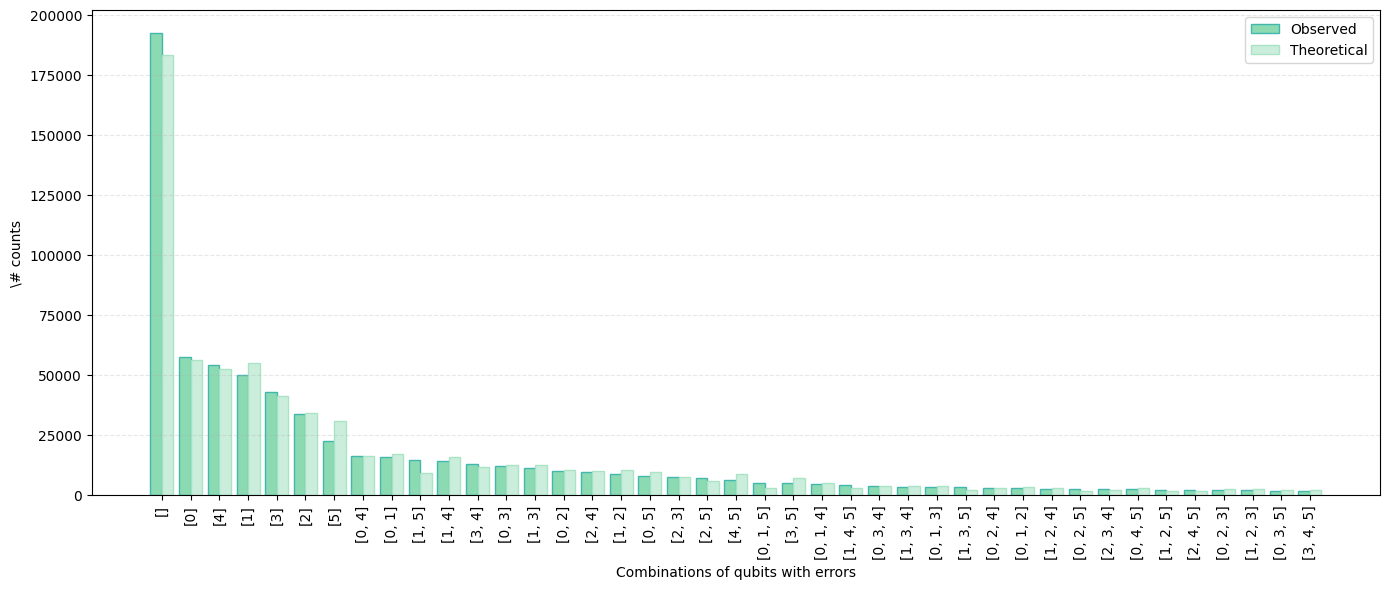

In [40]:
labels_both, observed_counts, theoretical_counts = error_vis_high.get_error_patterns(period, type="both", threshold=0.0)

# ---- Filtering step ----
max_count = max(max(observed_counts), max(theoretical_counts))
relative_threshold = 0.01  # show only bins >= 1% of the max
cutoff = max_count * relative_threshold

filtered_labels = []
filtered_observed = []
filtered_theoretical = []

for label, obs, theo in zip(labels_both, observed_counts, theoretical_counts):
    if obs >= cutoff or theo >= cutoff:
        filtered_labels.append(label)
        filtered_observed.append(obs)
        filtered_theoretical.append(theo)

# ---- Superposed Bar Plot ----
x = range(len(filtered_labels))
width = 0.4

plt.figure(figsize=(14,6))
plt.bar([i - width/2 for i in x], filtered_observed, width=width, 
        label="Observed", color=color_5, edgecolor=color_4)
plt.bar([i + width/2 for i in x], filtered_theoretical, width=width, 
        label="Theoretical", color=color_5_light, alpha=0.95, edgecolor=color_5_light_dark)
plt.xticks(x, filtered_labels, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_high.pdf", format='pdf')
plt.show()


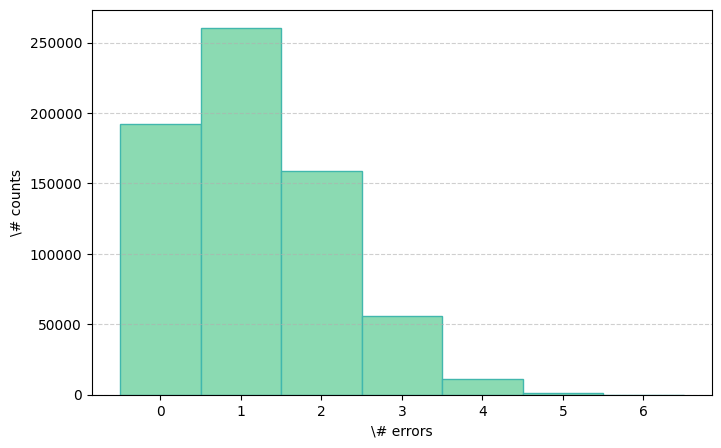

In [41]:
plt.figure(figsize=(8,5))
plt.hist(total_errors_high, bins=range(max(total_errors_high) + 2), align='left', color=color_5, edgecolor=color_4)
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("error_histogram_high_1.pdf", format='pdf')
plt.show()

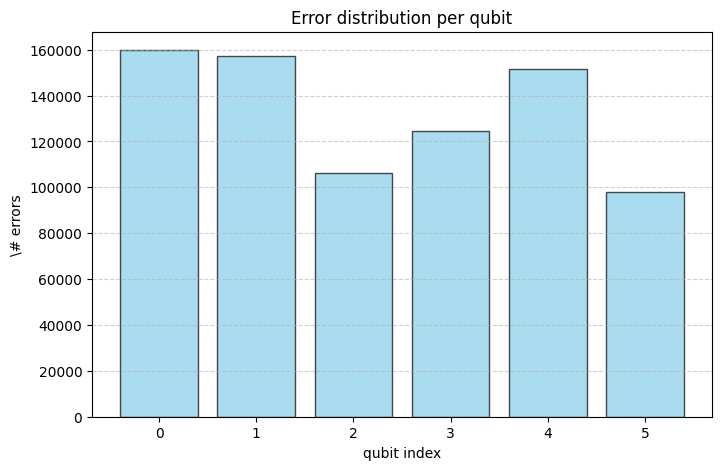

In [42]:
errors_per_qubit = errors_dict_high["high_period_errors"]["errors_per_qubit"]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(range(len(errors_per_qubit)), errors_per_qubit, color='skyblue', alpha=0.7, edgecolor='black')

# Etiquetas
plt.xlabel("qubit index")
plt.ylabel(r"\# errors")
plt.title("Error distribution per qubit")
plt.xticks(range(len(errors_per_qubit)))  # Marcamos los qubits en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [43]:
print("Errors per qubit:", np.array(errors_per_qubit)/sum(errors_per_qubit))

Errors per qubit: [0.20046723 0.19700876 0.13351859 0.15618926 0.19008931 0.12272685]


### **Posible cosmic ray?**

In [44]:
t_peaks = [27.963,30.499,45.408,58.245,87.237,100.895]
do_fit = [True, True, True, True, True, True]

In [45]:
# --- Exponential decay model (same as before) ---
def exp_decay_peak(t, A, tau, B, t0):
    return np.where(t >= t0, A * np.exp(-(t - t0) / tau) + B, B)

In [46]:
results_high = {}

window_low = -0.01  # seconds before peak

for idx, t_central in enumerate(t_peaks):

    errors_obj = ErrorAnalyzer(
        repetition_period = rep_high_1,
        init_state = init,
        measurements = bits_high_1,
        verbose=0,
        threshold=0.000120,
        center_time = t_central,
        window = (window_low, 0.015)
    )
    errors_dict = errors_obj.get_errors()

    total_errors = np.array(errors_dict['high_period_errors']['total_errors'])
    times_data = np.array(errors_dict['high_period_errors']['times'])

    # --- If fit is disabled, just plot the raw data ---
    if not do_fit[idx]:
        print(f"Event {idx}: skipped fit, only plotting data.")
        
        plt.figure(figsize=(7,6))
        plt.plot(times_data, total_errors, '-', color=color_5, linewidth=1, alpha=0.9)
        plt.vlines(t_central, ymin=total_errors.min(), ymax=total_errors.max(),
                   color=color_magma_4, linestyles='dashed', linewidth=1.5, label="Impact time")
        plt.xlabel("time (s)")
        plt.ylabel(r"\# errors")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        if output_graphs:
            plt.savefig(f"cr_high_high_{idx}.pdf", format='pdf')
        plt.close()
        continue

    # --- Fit is enabled ---
    mask = (times_data > t_central) & (times_data < t_central + 0.02)
    t_fit_data = times_data[mask]
    y_fit_data = total_errors[mask]

    if len(t_fit_data) < 5:
        print(f"Skipping index {idx}, not enough points in window.")
        continue

    try:
        popt, pcov = curve_fit(
            lambda t, A, tau, B: exp_decay_peak(t, A, tau, B, t_central),
            t_fit_data, y_fit_data,
            p0=[max(y_fit_data), 0.005, min(y_fit_data)],
            maxfev=20000
        )
        A, tau, B = popt
        dA, dtau, dB = np.sqrt(np.diag(pcov))

        # chi-square
        residuals = y_fit_data - exp_decay_peak(t_fit_data, A, tau, B, t_central)
        chi2 = np.sum(residuals**2)
        dof = len(y_fit_data) - len(popt)
        chi2_red = chi2 / dof if dof > 0 else np.nan

        results_high[idx] = (tau, dtau, chi2, dof, chi2_red)

        # --- Plot with fit ---
        plt.figure(figsize=(7,6))
        plt.plot(times_data, total_errors, '-', color=color_5, linewidth=1, alpha=0.9)
        t_fit_line = np.linspace(t_central, t_central + 0.015, 500)
        plt.plot(t_fit_line, exp_decay_peak(t_fit_line, A, tau, B, t_central),
                 color=color_magma_1, linewidth=2, label="Exponential fit")
        plt.vlines(t_central, ymin=total_errors.min(), ymax=total_errors.max()+0.9,
                   color=color_magma_1, linestyles='dashed', linewidth=2, label="Impact time")
        plt.xlabel("time (s)")
        plt.ylabel(r"\# errors")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        if output_graphs:
            plt.savefig(f"cr_high_{idx}.pdf", format='pdf')
        plt.close()

        # --- Print results ---
        print(f"Event {idx}: t0 = {t_central:.3f} s")
        print(f"   τ = {tau*1000:.2f} ± {dtau*1000:.2f} ms")
        print(f"   χ² = {chi2:.2f}, dof = {dof}, χ²_red = {chi2_red:.2f}")

    except RuntimeError:
        print(f"Fit did not converge for event {idx}.")

Event 0: t0 = 27.963 s
   τ = 2.22 ± 0.67 ms
   χ² = 99.62, dof = 97, χ²_red = 1.03
Event 1: t0 = 30.499 s
   τ = 3.82 ± 0.67 ms
   χ² = 109.01, dof = 97, χ²_red = 1.12
Event 2: t0 = 45.408 s
   τ = 1.54 ± 0.35 ms
   χ² = 77.02, dof = 97, χ²_red = 0.79
Event 3: t0 = 58.245 s
   τ = 3.05 ± 0.60 ms
   χ² = 101.25, dof = 97, χ²_red = 1.04
Event 4: t0 = 87.237 s
   τ = 1.75 ± 0.56 ms
   χ² = 108.67, dof = 97, χ²_red = 1.12
Event 5: t0 = 100.895 s
   τ = 3.87 ± 0.97 ms
   χ² = 98.74, dof = 97, χ²_red = 1.02


In [47]:
index = 1
t_central=t_peaks[index]

errors_obj_high_1_sel = ErrorAnalyzer(repetition_period = rep_high_1, init_state = init, measurements = bits_high_1, 
                               verbose=0, threshold=0.000120, center_time=t_central, window=(-0.01, 0.015))
error_vis_high_1_sel = ErrorVisualizer(errors_obj_high_1_sel)


errors_dict_high_1_sel = errors_obj_high_1_sel.get_errors()

states_high_1_sel = errors_dict_high_1_sel["high_period_errors"]["states"]
total_errors_high_1_sel = np.array(errors_dict_high_1_sel['high_period_errors']['total_errors'])
times_high_1_sel = np.array(errors_dict_high_1_sel['high_period_errors']['times'])

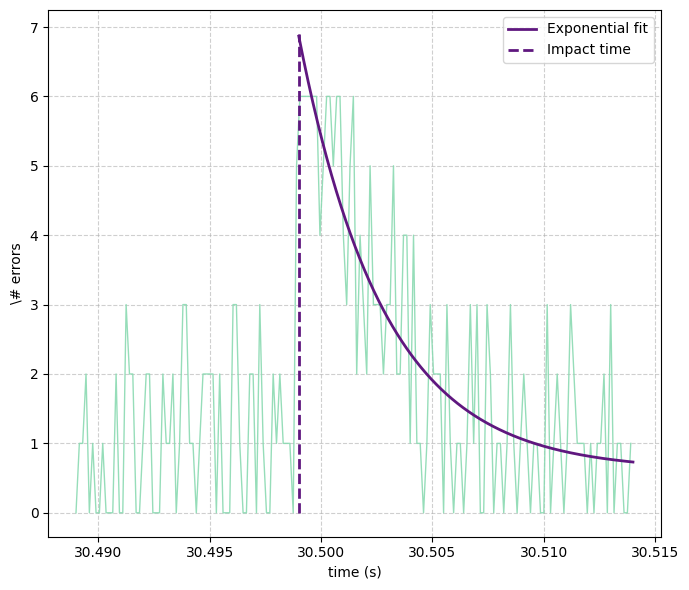

In [48]:
mask = (times_high_1_sel > t_central) & (times_high_1_sel < t_central + 0.02)
t_fit_data = times_high_1_sel[mask]
y_fit_data = total_errors_high_1_sel[mask]

popt, pcov = curve_fit(
            lambda t, A, tau, B: exp_decay_peak(t, A, tau, B, t_central),
            t_fit_data, y_fit_data,
            p0=[max(y_fit_data), 0.004, min(y_fit_data)],
            maxfev=20000
        )

A, tau, B = popt
dA, dtau, dB = np.sqrt(np.diag(pcov))



# chi-square
residuals = y_fit_data - exp_decay_peak(t_fit_data, A, tau, B, t_central)
chi2 = np.sum(residuals**2)
dof = len(y_fit_data) - len(popt)
chi2_red = chi2 / dof if dof > 0 else np.nan


        # --- Plot with fit ---
plt.figure(figsize=(7,6))
plt.plot(times_high_1_sel, total_errors_high_1_sel, '-', color=color_5, linewidth=1, alpha=0.9)
t_fit_line = np.linspace(t_central, t_central + 0.015, 500)
plt.plot(t_fit_line, exp_decay_peak(t_fit_line, A, tau, B, t_central),
                 color=color_magma_1, linewidth=2, label="Exponential fit")
plt.vlines(t_central, ymin=total_errors_high_1_sel.min(), ymax=total_errors_high_1_sel.max()+0.9,
                   color=color_magma_1, linestyles='dashed', linewidth=2, label="Impact time")
plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
if output_graphs:
    plt.savefig(f"cr_high_{idx}.pdf", format='pdf')

[DEBUG] Experimental keys: 44
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 167, Total theo: 166.99999999999994
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


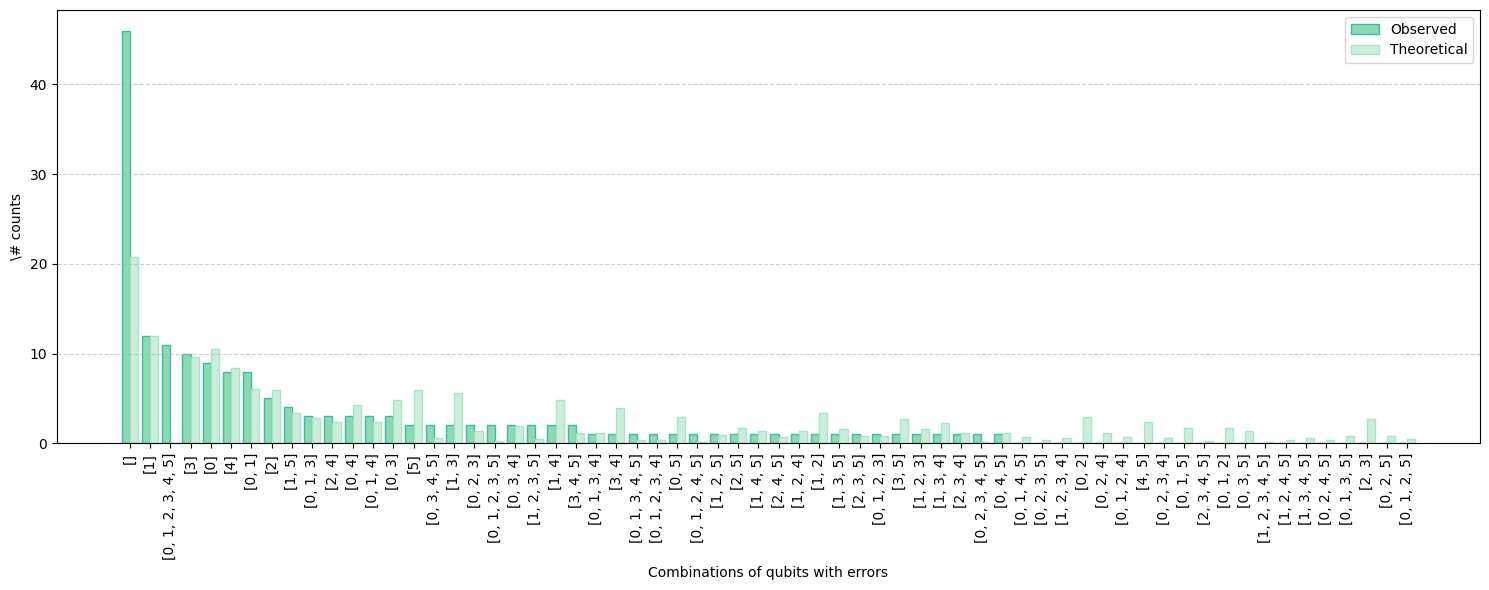

In [49]:
labels_both_1, observed_counts_1, theoretical_counts_1 = error_vis_high_1_sel.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both_1))
width = 0.4

plt.figure(figsize=(15, 6))
plt.bar([i - width/2 for i in x], observed_counts_1, width=width, label="Observed", color=color_5, edgecolor=color_4)
plt.bar([i + width/2 for i in x], theoretical_counts_1, width=width, label="Theoretical", color=color_5_light,alpha = 0.95, edgecolor=color_5_light_dark)
plt.xticks(x, labels_both_1, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_high_cr.pdf", format='pdf')
plt.show()

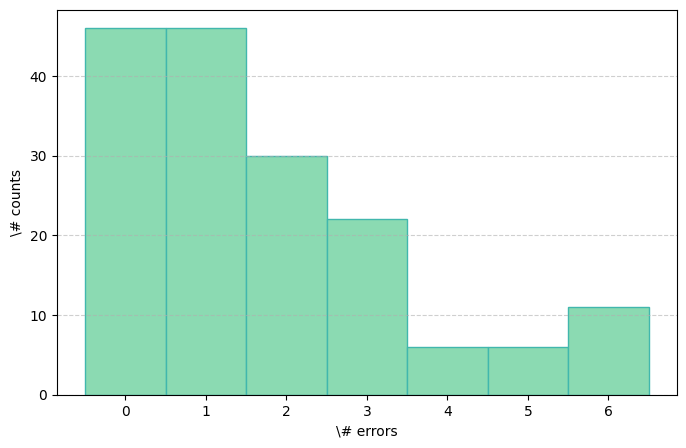

In [50]:
plt.figure(figsize=(8,5))
plt.hist(total_errors_high_1_sel, bins=range(max(total_errors_high_1_sel) + 2), align='left', color=color_5, edgecolor=color_4)
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("error_histogram_high_1_cr.pdf", format='pdf')
plt.show()


In [51]:
external_qubit_probs = [0.20046723, 0.19700876, 0.13351859, 0.15618926, 0.19008931, 0.12272685]

In [52]:
index = 1
t_central=t_peaks[index]

errors_obj_high_1_sel = ErrorAnalyzer(repetition_period = rep_high_1, init_state = init, measurements = bits_high_1, 
                               verbose=0, threshold=0.000120, center_time=t_central, window=(-0.0001, 0.00382), external_error_probs=external_qubit_probs)
error_vis_high_1_sel = ErrorVisualizer(errors_obj_high_1_sel)


errors_dict_high_1_sel = errors_obj_high_1_sel.get_errors()

states_high_1_sel = errors_dict_high_1_sel["high_period_errors"]["states"]
total_errors_high_1_sel = np.array(errors_dict_high_1_sel['high_period_errors']['total_errors'])
times_high_1_sel = np.array(errors_dict_high_1_sel['high_period_errors']['times'])

[DEBUG] Experimental keys: 16
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 27, Total theo: 27.000000000000014
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64
Total observed counts: 27
Total theoretical counts: 27.000000000000007
Number of measurements in window: 27
External probabilities: [0.20046723, 0.19700876, 0.13351859, 0.15618926, 0.19008931, 0.12272685]


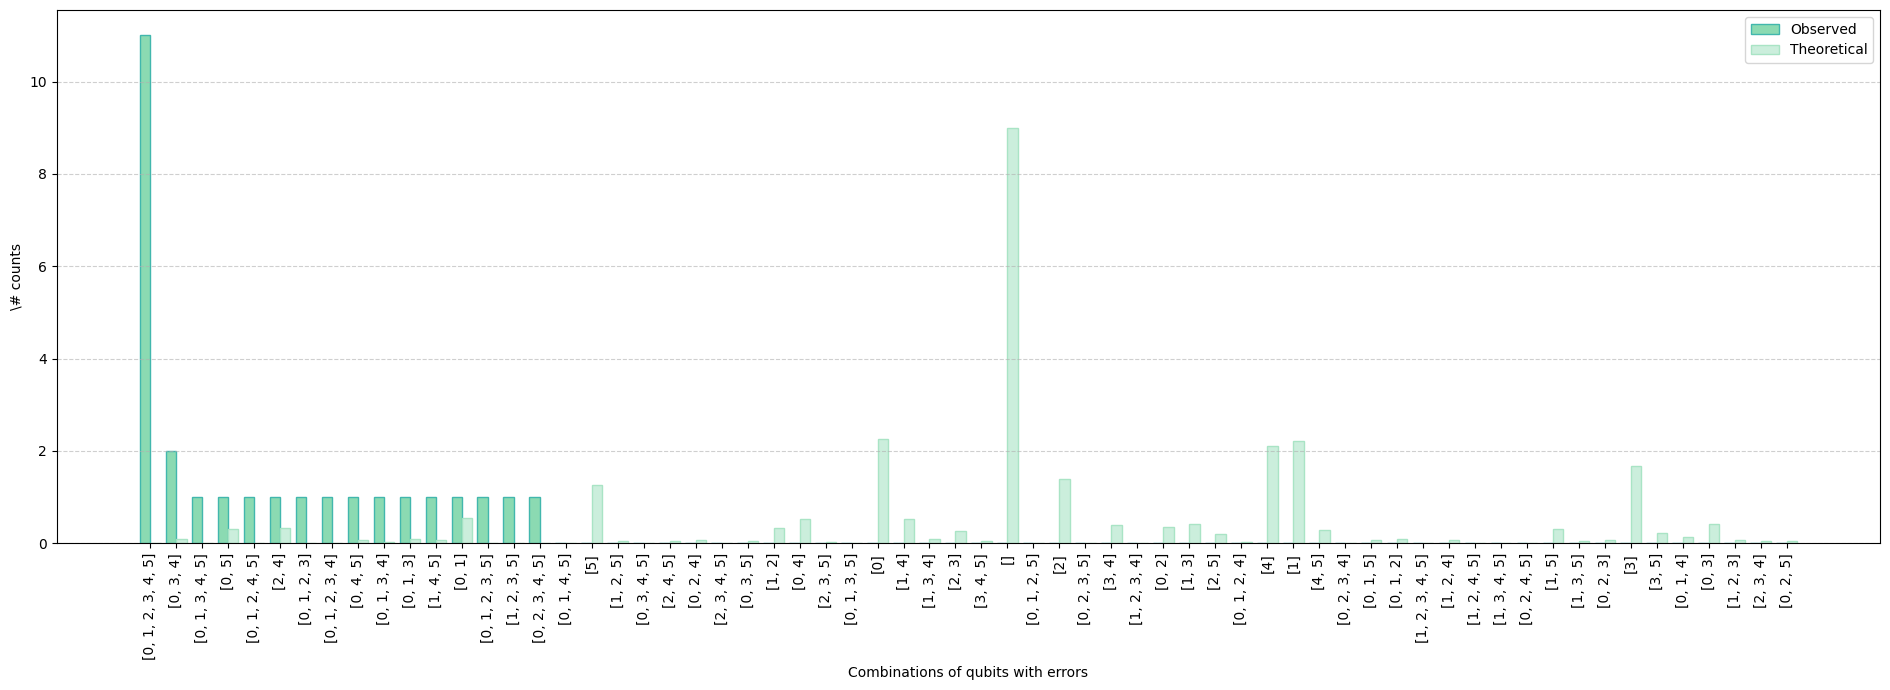

In [53]:
labels_both_1, observed_counts_1, theoretical_counts_1 = error_vis_high_1_sel.get_error_patterns(period, type="both", threshold=0.0)

# Debug information
print(f"Total observed counts: {sum(observed_counts_1)}")
print(f"Total theoretical counts: {sum(theoretical_counts_1)}")
print(f"Number of measurements in window: {len(total_errors_high_1_sel)}")
print(f"External probabilities: {external_qubit_probs}")

# ---- Superposed Bar Plot ----
x = range(len(labels_both_1))
width = 0.4

plt.figure(figsize=(19, 7))
plt.bar([i - width/2 for i in x], observed_counts_1, width=width, label="Observed", color=color_5, edgecolor=color_4)
plt.bar([i + width/2 for i in x], theoretical_counts_1, width=width, label="Theoretical", color=color_5_light,alpha = 0.95, edgecolor=color_5_light_dark)
plt.xticks(x, labels_both_1, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_high_cr.pdf", format='pdf')
plt.show()

### **2. Initial state: $\ket{0}$**

In [54]:
bits_high_0, rep_high_0, init, backend_high_0, extra_high_0 = read_data("data/results_cosmic_high_period_0.txt")

In [55]:
print("Bitstrings:", bits_high_0[:5])     # first 5 measured states
print("Repetition period:", rep_high_0)
print("Init state:", init)
print("Backend:", backend_high_0)
print("Batch IDs:", extra_high_0.get("batch"))
print("Shot IDs:", extra_high_0.get("shot"))
print("Abs times:", extra_high_0.get("abstime"))


Bitstrings: ['000000' '000000' '000000' '100001' '100011']
Repetition period: 0.00015
Init state: None
Backend: qmio
Batch IDs: [ 1  1  1 ... 83 83 83]
Shot IDs: [     1      2      3 ... 679934 679935 679936]
Abs times: [  1.914298   1.914298   1.914298 ... 158.527913 158.527913 158.527913]


In [56]:
errors_obj_high_0 = ErrorAnalyzer(repetition_period = rep_high_0, init_state = 0, 
                                  measurements = bits_high_0, threshold=0.000120, verbose=2)
errors_dict_high_0 = errors_obj_high_0.get_errors()

The analysis was performed using the *high repetition period* approach 
(repetition_period ≥ 1.2e-10 μs). The error dictionary contains:

- Key: 'high_period_errors' → Returns two arrays with 679936 measurements:
  - 'error_counts': Array with the number of errors associated with each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [57]:
states_high_0 = errors_dict_high_0["high_period_errors"]["states"]
total_errors_high_0 = errors_dict_high_0['high_period_errors']['total_errors']
times_high_0 = errors_dict_high_0['high_period_errors']['times']

print('number of total errors:',sum(total_errors_high_0))


number of total errors: 419071


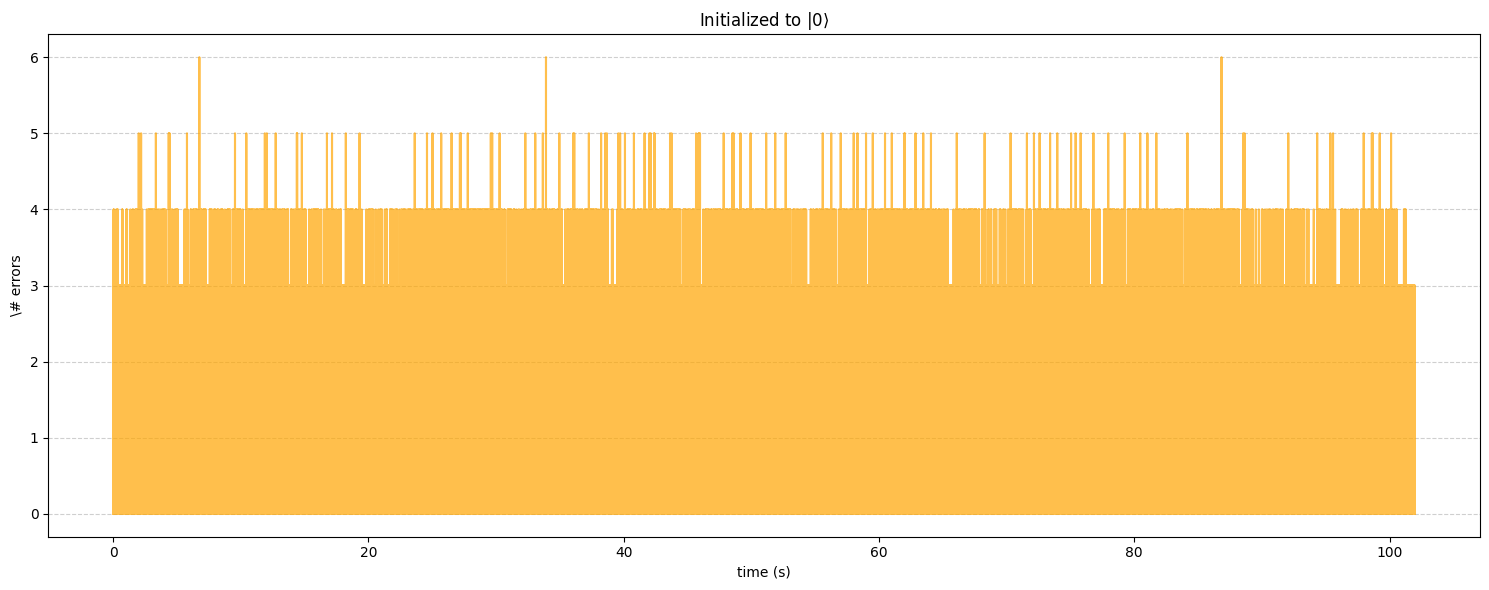

In [58]:
plt.figure(figsize=(15,6))

plt.plot(times_high_0, total_errors_high_0, '-', color = 'orange', markersize=3, alpha=0.7)

plt.xlabel("time (s)")
plt.ylabel(r"\# errors")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.title(r'Initialized to $|0\rangle$')

plt.tight_layout()
plt.show()

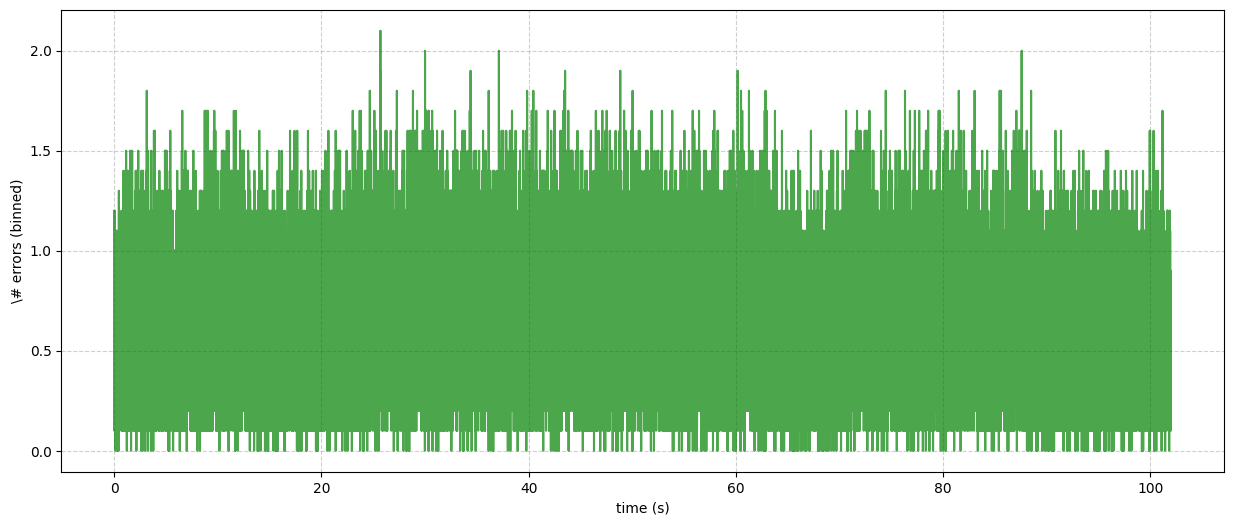

In [59]:
# Example: group every 6 points
bin_size = 10

# convert to arrays
times_high_0 = np.array(times_high_0)
total_errors_high_0 = np.array(total_errors_high_0)

# number of full bins
n_bins = len(total_errors_high_0) // bin_size

# reshape and take mean
binned_times = times_high_0[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors_high_0[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color='green', alpha=0.7)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors (binned)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

mean number of errors: 0.6163340343858927


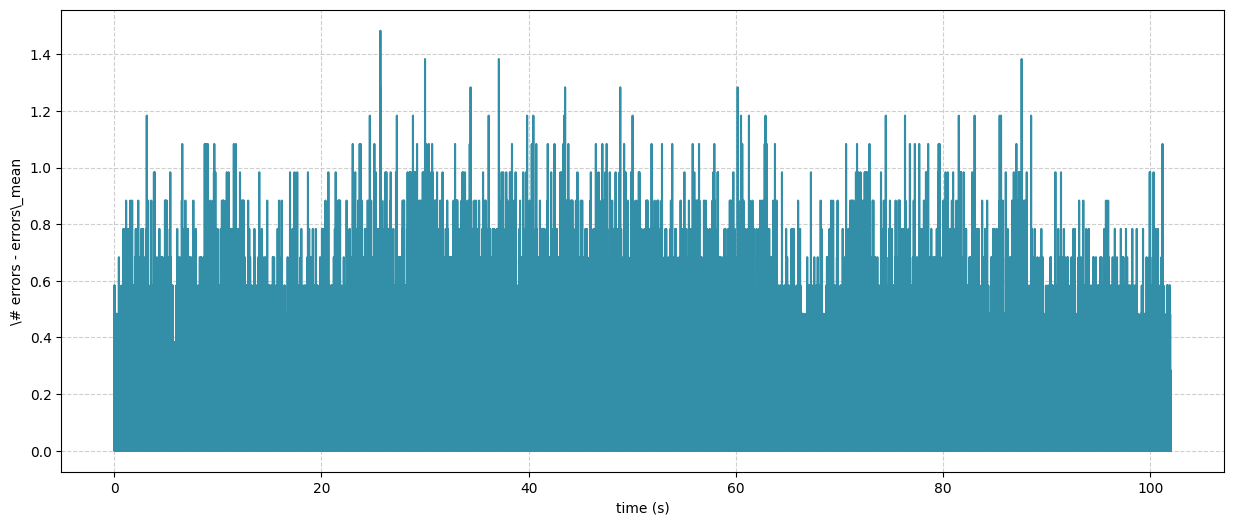

In [60]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
print('mean number of errors:', baseline)
signal = binned_errors - baseline  # subtract baseline

# optionally clip negatives to zero (if you only care about positive peaks)
signal = np.clip(signal, 0, None)

# ---------------- PLOT ----------------
plt.figure(figsize=(15,6))
plt.plot(binned_times, signal, '-', color=color_3)
plt.xlabel("time (s)")
plt.ylabel(r"\# errors - errors\_mean")
plt.grid(True, linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("errors_time_high_0.pdf", format='pdf')
plt.show()

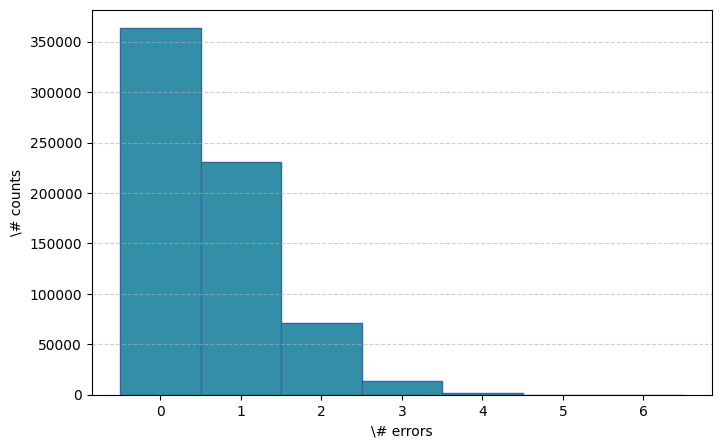

In [61]:
plt.figure(figsize=(8,5))
plt.hist(total_errors_high_0, bins=range(max(total_errors_high_0) + 2), align='left', color=color_3, edgecolor=color_2)
plt.xlabel(r"\# errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
if output_graphs:  
    plt.savefig("error_histogram_high_0.pdf", format='pdf')
plt.show()

The analysis was performed using the *high repetition period* approach 
(repetition_period ≥ 1.2e-10 μs). The error dictionary contains:

- Key: 'high_period_errors' → Returns two arrays with 679936 measurements:
  - 'error_counts': Array with the number of errors associated with each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).


[DEBUG] Experimental keys: 64
[DEBUG] Theoretical keys: 64
[DEBUG] All keys: 64
[DEBUG] Total exp: 679936, Total theo: 679935.9999999993
[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


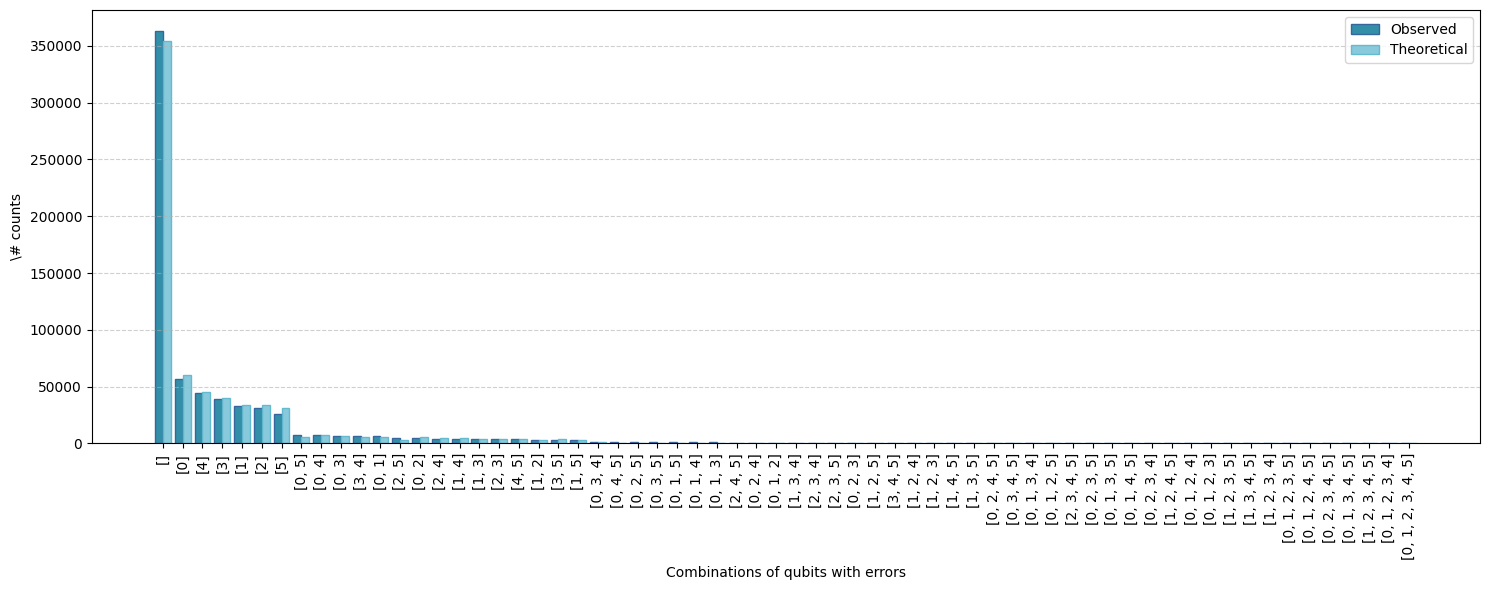

In [62]:

error_vis_high_0 = ErrorVisualizer(error_obj=errors_obj_high_0)
period = "high"
labels_both_0, observed_counts_0, theoretical_counts_0 = error_vis_high_0.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both_0))
width = 0.4

plt.figure(figsize=(15, 6))
plt.bar([i - width/2 for i in x], observed_counts_0, width=width, label="Observed", color=color_3, edgecolor=color_2)
plt.bar([i + width/2 for i in x], theoretical_counts_0, width=width, label="Theoretical", color=color_3_light,alpha = 0.95, edgecolor=color_3_light_dark)
plt.xticks(x, labels_both_0, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
#plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_high_0.pdf", format='pdf')
plt.show()

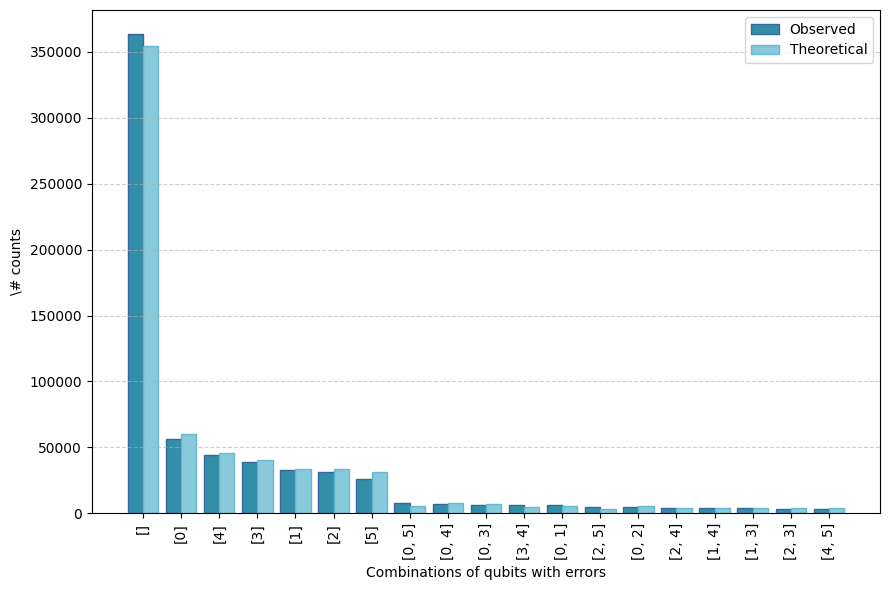

In [63]:
# ---- Filtering step ----
abs_threshold = 1            # minimum number of counts to show
relative_threshold = 0.01       # keep bins >= 1% of the maximum

max_count = max(max(observed_counts_0), max(theoretical_counts_0))
cutoff = max(abs_threshold, max_count * relative_threshold)

filtered_labels = []
filtered_observed = []
filtered_theoretical = []

for label, obs, theo in zip(labels_both_0, observed_counts_0, theoretical_counts_0):
    if obs >= cutoff or theo >= cutoff:  # keep bin if either count exceeds cutoff
        filtered_labels.append(label)
        filtered_observed.append(obs)
        filtered_theoretical.append(theo)

# ---- Superposed Bar Plot ----
x = range(len(filtered_labels))
width = 0.4

plt.figure(figsize=(9, 6))
plt.bar([i - width/2 for i in x], filtered_observed, width=width,
        label="Observed", color=color_3, edgecolor=color_2)
plt.bar([i + width/2 for i in x], filtered_theoretical, width=width,
        label="Theoretical", color=color_3_light, alpha=0.95, edgecolor=color_3_light_dark)
plt.xticks(x, filtered_labels, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel(r"\# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
if output_graphs:  
    plt.savefig("error_patterns_high_0.pdf", format='pdf')
plt.show()

